<a href="https://colab.research.google.com/github/kangmg/image2music/blob/main/backend/data/get_mel_spectrogram.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

> **Mel spectrogram 얻기**

LastFM을 이용하여 수집한 meta data(youtube url을 포함)로부터 유튜브 음원을 추출하고 이를 mel spectrogram으로 변환 후 저장하는 노트북

`프로젝트 기간이 종료된 후 작동하지 않을 수 있음`

1. 코드를 실행시키면, mel_array.zip 형태로 전체 mel spectrogram이 압축 저장되고, 각 mel spectrogram은 *.npy 형태의 넘파이 바이너리 파일로 저장됨

2. 파일을 로드하고 싶으면 다음 코드로 plot 가능함

```python
import numpy as np
import matplotlib.pyplot as plt

data_path = 'path/to/mel_spectrogram/data'
np_array = np.load(data_path)
plt.imshow(np_array, aspect='auto' , cmap="afmhot")
```


In [ ]:
#@title 데이터 및 패키지 다운로드
#@markdown meta data와 음성 데이터를 다루기 위한 패키지를 다운로드 합니다.

# meta data download
!git clone -q https://github.com/kangmg/image2music
!mkdir metadata
!mv ./image2music/backend/data/mood_data_csv/* ./metadata
!rm -r ./image2music

# package downlaod
!pip install -q pytube
!pip install -q ffmpeg

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.6/57.6 kB 706.2 kB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [ ]:
#@title setting

from pytube import YouTube
import time
import os
import librosa
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
from scipy.io import wavfile
from IPython.display import clear_output
from moviepy.video.io.ffmpeg_tools import ffmpeg_extract_audio
from scipy.io.wavfile import write
import glob
import shutil
import matplotlib.pyplot as plt

def convertor(path, id, sampling_rate=22050):
    '''
    mp4 -> wav (first 30 seconds)
    Ensure the audio has a consistent length of sampling_rate * 30 samples.
    sampling_rate: sampling rate for the output audio file (default is 22050 Hz)
    '''
    input_path = os.path.join(path, f"{id}.mp4")
    output_wav_path = os.path.join(path, f"{id}.wav")
    temp_output_path = os.path.join(path, f"{id}_temp.wav")
    # Extract audio from the video using ffmpeg directly
    ffmpeg_extract_audio(input_path, temp_output_path, fps=sampling_rate, )
    time.sleep(0.1)
    # Load the audio data from the temporary file
    sr, audio_array = wavfile.read(temp_output_path)
    # Ensure the audio has a consistent length of sampling_rate * 30 samples
    target_length = int(sampling_rate * 30)
    # Flatten to mono if stereo
    if audio_array.ndim > 1:
        audio_array = audio_array.mean(axis=1)
    # ensure 30 sec
    audio_array = audio_array[:target_length]
    # Save the adjusted audio data to the output path
    write(output_wav_path, sampling_rate, audio_array)

    # Remove the temporary and original MP4 files
    os.remove(temp_output_path)
    os.remove(input_path)


def downUrl(url:str,download_path="/content/audio/", sr=22050)->None:
  '''
  url에 해당하는 유튜브 영상을 오디오 형식으로 저장
  '''
  yt = YouTube(url)
  yt_id = yt.video_id
  audio = yt.streams.filter(only_audio=True, audio_codec="mp4a.40.5" if True else "mp4a.40.2")[0] # 변경 필요
  name = yt_id + ".mp4"
  try:
    audio.download(output_path=download_path, filename=name)
    time.sleep(0.2)
    convertor(download_path, yt_id,  sampling_rate=sr)
  except Exception as E:
    print("[Warning] ",audio.video_id, " : 영상 다운 실패")

def normalize(spec):
    '''
    normalize mel spectrogram array
    '''
    eps=1e-6

    # Z-score normalization
    mean = spec.mean()
    std = spec.std()
    spec_norm = (spec - mean) / (std + eps)
    spec_min, spec_max = spec_norm.min(), spec_norm.max()

    # Min-max scaling
    spec_scaled = 255 * (spec_norm - spec_min) / (spec_max - spec_min)
    spec_scaled = spec_scaled.astype(np.uint8)

    return spec_scaled


def save_mel_spectrogram(wav_file, save_path):
    '''
    Generate and save Mel spectrogram as a NumPy array.

    Parameters:
    wav_file (str): Path to the input WAV file.
    save_path (str): Path to save the Mel spectrogram array.
    '''
    y, sr = librosa.load(wav_file)
    S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
    S_dB = librosa.power_to_db(S, ref=np.max)
    S_dB = normalize(S_dB)
    np.save(save_path, S_dB)


def process_wav_files(input_dir, output_dir="auto"):
  '''
  input_dir에 존재한 *.wav 파일을 output_dir에
  mel spectrogram array를 *.npy로 저장
  '''
  if output_dir == "auto":
    output_dir = input_dir + "_mel"
    os.makedirs(output_dir, exist_ok=True)

  files = os.listdir(input_dir)
  for file in tqdm(files):
    if file.endswith('.wav'):
      wav_file = os.path.join(input_dir, file)
      save_mel_spectrogram(wav_file, os.path.join(output_dir, file.replace('.wav', '.npy')))



file_list = os.listdir('./metadata')
mood_list = list(mood.split(".")[0] for mood in file_list)

# 다운로드 실패 url 리스트
failed_url = list()


# 용량 이슈로 9번에 나눠서 진행
'''
mood_list_0_4 = mood_list[:5]
file_list_0_4 = file_list[:5]

mood_list_5_9 = mood_list[5:10]
file_list_5_9 = file_list[5:10]

mood_list_10_14 = mood_list[10:15]
file_list_10_14 = file_list[10:15]

mood_list_15_19 = mood_list[15:20]
file_list_15_19 = file_list[15:20]

mood_list_20_24 = mood_list[20:25]
file_list_20_24 = file_list[20:25]

mood_list_25_29 = mood_list[25:30]
file_list_25_29 = file_list[25:30]

mood_list_30_34 = mood_list[30:35]
file_list_30_34 = file_list[30:35]

mood_list_35_39 = mood_list[35:40]
file_list_35_39 = file_list[35:40]

mood_list_40_44 = mood_list[40:]
file_list_40_44 = file_list[40:]
'''
print()

```
각 셀마다 20~50 분정도의 run time이 걸림

전체 약 35 m * 9 = 315 m ( ~ 6 h )
```

In [ ]:
#@title mood_list_0_4

mood_list_0_4 = mood_list[:5]
file_list_0_4 = file_list[:5]

# file download
for mood, file in zip(mood_list_0_4, file_list_0_4):
  tmp_df = pd.read_csv(f'./metadata/{file}')
  os.mkdir(mood)
  print(f"- {mood} Progress")
  for yt_url in tqdm(tmp_df['youtube_url']):
    try:
      downUrl(url=yt_url, download_path=mood)
    except Exception as E:
      print(f"{E}\n")
      print("[Warning] Fail to download : ",yt_url)
      failed_url.append(yt_url)
  clear_output()

!echo "Download Done!"

#get mel spectrogram
process_wav_files('/content/Positive')
process_wav_files('/content/Complex')
process_wav_files('/content/Lonely')
process_wav_files('/content/Cheerful')
process_wav_files('/content/Driving')


# *_mel 폴더들을 mel_array 폴더로 이동시키기

folders = list(os.path.basename(folderpath) for folderpath in glob.glob('/content/*_mel'))
for dir in folders:
  shutil.move(dir, os.path.join("mel_array_0_4", dir) )


# 파일 압축
!zip -r mel_array_0_4.zip mel_array_0_4
clear_output()

total_num = len(glob.glob('/content/mel_array_0_4/*_mel/*.npy'))
print('[ mood_list_0_4 ]')
print(f"Number of mel spectrogram : {total_num}")

In [ ]:
#@title mood_list_5_9

mood_list_5_9 = mood_list[5:10]
file_list_5_9 = file_list[5:10]

for mood, file in zip(mood_list_5_9, file_list_5_9):
  tmp_df = pd.read_csv(f'./metadata/{file}')
  os.mkdir(mood)
  print(f"- {mood} Progress")
  for yt_url in tqdm(tmp_df['youtube_url']):
    try:
      downUrl(url=yt_url, download_path=mood)
    except Exception as E:
      print(f"{E}\n")
      print("[Warning] Fail to download : ",yt_url)
      failed_url.append(yt_url)
  clear_output()

!echo "Download Done!"

# get mel spectrogram
process_wav_files('/content/Romantic')
process_wav_files('/content/Sweet')
process_wav_files('/content/Atmospheric')
process_wav_files('/content/Sexy')
process_wav_files('/content/Melancholy')


# *_mel 폴더들을 mel_array 폴더로 이동시키기
folders = list(os.path.basename(folderpath) for folderpath in glob.glob('/content/*_mel'))
for dir in folders:
  shutil.move(dir, os.path.join("mel_array_5_9", dir) )

# 파일 압축
!zip -r mel_array_5_9.zip mel_array_5_9
clear_output()

total_num = len(glob.glob('/content/mel_array_5_9/*_mel/*.npy'))
print('[ mood_list_5_9 ]')
print(f"Number of mel spectrogram : {total_num}")

In [ ]:
#@title mood_list_10_14

mood_list_10_14 = mood_list[10:15]
file_list_10_14 = file_list[10:15]

# file download
for mood, file in zip(mood_list_10_14, file_list_10_14):
  tmp_df = pd.read_csv(f'./metadata/{file}')
  os.mkdir(mood)
  print(f"- {mood} Progress")
  for yt_url in tqdm(tmp_df['youtube_url']):
    try:
      downUrl(url=yt_url, download_path=mood)
    except Exception as E:
      print(f"{E}\n")
      print("[Warning] Fail to download : ",yt_url)
      failed_url.append(yt_url)
  clear_output()

!echo "Download Done!"

#get mel spectrogram
process_wav_files('/content/Scary')
process_wav_files('/content/Gloomy')
process_wav_files('/content/Uplifting')
process_wav_files('/content/Angry')
process_wav_files('/content/Sentimental')


# *_mel 폴더들을 mel_array 폴더로 이동시키기

folders = list(os.path.basename(folderpath) for folderpath in glob.glob('/content/*_mel'))
for dir in folders:
  shutil.move(dir, os.path.join("mel_array_10_14", dir) )


# 파일 압축
!zip -r mel_array_10_14.zip mel_array_10_14
clear_output()

total_num = len(glob.glob('/content/mel_array_10_14/*_mel/*.npy'))
print('[ mood_list_10_14 ]')
print(f"Number of mel spectrogram : {total_num}")

In [ ]:
#@title mood_list_15_19

mood_list_15_19 = mood_list[15:20]
file_list_15_19 = file_list[15:20]

for mood, file in zip(mood_list_15_19, file_list_15_19):
  tmp_df = pd.read_csv(f'./metadata/{file}')
  os.mkdir(mood)
  print(f"- {mood} Progress")
  for yt_url in tqdm(tmp_df['youtube_url']):
    try:
      downUrl(url=yt_url, download_path=mood)
    except Exception as E:
      print(f"{E}\n")
      print("[Warning] Fail to download : ",yt_url)
      failed_url.append(yt_url)
  clear_output()

!echo "Download Done!"

# get mel spectrogram
process_wav_files('/content/Nostalgic')
process_wav_files('/content/Lovely')
process_wav_files('/content/Sensual')
process_wav_files('/content/Bright')
process_wav_files('/content/Cold')


# *_mel 폴더들을 mel_array 폴더로 이동시키기
folders = list(os.path.basename(folderpath) for folderpath in glob.glob('/content/*_mel'))
for dir in folders:
  shutil.move(dir, os.path.join("mel_array_15_19", dir) )

# 파일 압축
!zip -r mel_array_15_19.zip mel_array_15_19
clear_output()

total_num = len(glob.glob('/content/mel_array_15_19/*_mel/*.npy'))
print('[ mood_list_15_19 ]')
print(f"Number of mel spectrogram : {total_num}")

[ mood_list_15_19 ]
Number of mel spectrogram : 949


In [ ]:
#@title mood_list_20_24

mood_list_20_24 = mood_list[20:25]
file_list_20_24 = file_list[20:25]

# file download
for mood, file in zip(mood_list_20_24, file_list_20_24):
  tmp_df = pd.read_csv(f'./metadata/{file}')
  os.mkdir(mood)
  print(f"- {mood} Progress")
  for yt_url in tqdm(tmp_df['youtube_url']):
    try:
      downUrl(url=yt_url, download_path=mood)
    except Exception as E:
      print(f"{E}\n")
      print("[Warning] Fail to download : ",yt_url)
      failed_url.append(yt_url)
  clear_output()

!echo "Download Done!"

#get mel spectrogram
process_wav_files('/content/Exciting')
process_wav_files('/content/Calm')
process_wav_files('/content/Lyrical')
process_wav_files('/content/Sad')
process_wav_files('/content/Earnest')


# *_mel 폴더들을 mel_array 폴더로 이동시키기

folders = list(os.path.basename(folderpath) for folderpath in glob.glob('/content/*_mel'))
for dir in folders:
  shutil.move(dir, os.path.join("mel_array_20_24", dir) )


# 파일 압축
!zip -r mel_array_20_24.zip mel_array_20_24
clear_output()

total_num = len(glob.glob('/content/mel_array_20_24/*_mel/*.npy'))
print('[ mood_list_20_24 ]')
print(f"Number of mel spectrogram : {total_num}")

[ mood_list_20_24 ]
Number of mel spectrogram : 889


In [ ]:
#@title mood_list_25_29

mood_list_25_29 = mood_list[25:30]
file_list_25_29 = file_list[25:30]

for mood, file in zip(mood_list_25_29, file_list_25_29):
  tmp_df = pd.read_csv(f'./metadata/{file}')
  os.mkdir(mood)
  print(f"- {mood} Progress")
  for yt_url in tqdm(tmp_df['youtube_url']):
    try:
      downUrl(url=yt_url, download_path=mood)
    except Exception as E:
      print(f"{E}\n")
      print("[Warning] Fail to download : ",yt_url)
      failed_url.append(yt_url)
  clear_output()

!echo "Download Done!"

# get mel spectrogram
process_wav_files('/content/Gentle')
process_wav_files('/content/Bittersweet')
process_wav_files('/content/Aggresive')
process_wav_files('/content/Energetic')
process_wav_files('/content/Fun')


# *_mel 폴더들을 mel_array 폴더로 이동시키기
folders = list(os.path.basename(folderpath) for folderpath in glob.glob('/content/*_mel'))
for dir in folders:
  shutil.move(dir, os.path.join("mel_array_25_29", dir) )

# 파일 압축
!zip -r mel_array_25_29.zip mel_array_25_29
clear_output()

total_num = len(glob.glob('/content/mel_array_25_29/*_mel/*.npy'))
print('[ mood_list_25_29 ]')
print(f"Number of mel spectrogram : {total_num}")

[ mood_list_25_29 ]
Number of mel spectrogram : 820


In [ ]:
#@title mood_list_30_34

mood_list_30_34 = mood_list[30:35]
file_list_30_34 = file_list[30:35]

# file download
for mood, file in zip(mood_list_30_34, file_list_30_34):
  tmp_df = pd.read_csv(f'./metadata/{file}')
  os.mkdir(mood)
  print(f"- {mood} Progress")
  for yt_url in tqdm(tmp_df['youtube_url']):
    try:
      downUrl(url=yt_url, download_path=mood)
    except Exception as E:
      print(f"{E}\n")
      print("[Warning] Fail to download : ",yt_url)
      failed_url.append(yt_url)
  clear_output()

!echo "Download Done!"

#get mel spectrogram
process_wav_files('/content/Epic')
process_wav_files('/content/Dreamy')
process_wav_files('/content/Relaxed')
process_wav_files('/content/Confident')
process_wav_files('/content/Dramatic')


# *_mel 폴더들을 mel_array 폴더로 이동시키기

folders = list(os.path.basename(folderpath) for folderpath in glob.glob('/content/*_mel'))
for dir in folders:
  shutil.move(dir, os.path.join("mel_array_30_34", dir) )


# 파일 압축
!zip -r mel_array_30_34.zip mel_array_30_34
clear_output()

total_num = len(glob.glob('/content/mel_array_30_34/*_mel/*.npy'))
print('[ mood_list_30_34 ]')
print(f"Number of mel spectrogram : {total_num}")

[ mood_list_30_34 ]
Number of mel spectrogram : 946


In [ ]:
#@title mood_list_35_39

mood_list_35_39 = mood_list[35:40]
file_list_35_39 = file_list[35:40]

for mood, file in zip(mood_list_35_39, file_list_35_39):
  tmp_df = pd.read_csv(f'./metadata/{file}')
  os.mkdir(mood)
  print(f"- {mood} Progress")
  for yt_url in tqdm(tmp_df['youtube_url']):
    try:
      downUrl(url=yt_url, download_path=mood)
    except Exception as E:
      print(f"{E}\n")
      print("[Warning] Fail to download : ",yt_url)
      failed_url.append(yt_url)
  clear_output()

!echo "Download Done!"

# get mel spectrogram
process_wav_files('/content/Smooth')
process_wav_files('/content/Light')
process_wav_files('/content/Strong')
process_wav_files('/content/Fierce')
process_wav_files('/content/Warm')


# *_mel 폴더들을 mel_array 폴더로 이동시키기
folders = list(os.path.basename(folderpath) for folderpath in glob.glob('/content/*_mel'))
for dir in folders:
  shutil.move(dir, os.path.join("mel_array_35_39", dir) )

# 파일 압축
!zip -r mel_array_35_39.zip mel_array_35_39
clear_output()

total_num = len(glob.glob('/content/mel_array_35_39/*_mel/*.npy'))
print('[ mood_list_35_39 ]')
print(f"Number of mel spectrogram : {total_num}")

[ mood_list_35_39 ]
Number of mel spectrogram : 960


In [ ]:
#@title mood_list_40_44

mood_list_40_44 = mood_list[40:]
file_list_40_44 = file_list[40:]

# file download
for mood, file in zip(mood_list_40_44, file_list_40_44):
  tmp_df = pd.read_csv(f'./metadata/{file}')
  os.mkdir(mood)
  print(f"- {mood} Progress")
  for yt_url in tqdm(tmp_df['youtube_url']):
    try:
      downUrl(url=yt_url, download_path=mood)
    except Exception as E:
      print(f"{E}\n")
      print("[Warning] Fail to download : ",yt_url)
      failed_url.append(yt_url)
  clear_output()

!echo "Download Done!"

#get mel spectrogram
process_wav_files('/content/Intimate')
process_wav_files('/content/Mysterious')
process_wav_files('/content/Serious')
process_wav_files('/content/Happy')
process_wav_files('/content/Intense')


# *_mel 폴더들을 mel_array 폴더로 이동시키기

folders = list(os.path.basename(folderpath) for folderpath in glob.glob('/content/*_mel'))
for dir in folders:
  shutil.move(dir, os.path.join("mel_array_40_44", dir) )


# 파일 압축
!zip -r mel_array_40_44.zip mel_array_40_44
clear_output()

total_num = len(glob.glob('/content/mel_array_40_44/*_mel/*.npy'))
print('[ mood_list_40_44 ]')
print(f"Number of mel spectrogram : {total_num}")

In [ ]:
#@title 전체 파일 압축
total_files = glob.glob('/content/mel_array_*/*_mel/*.npy')

!echo 전체 파일 수 : {len(total_files)}

if not os.path.isdir("mel_array"):
  os.mkdir('mel_array')

folders2compress = list(filter(os.path.isdir, glob.glob('mel_array_*')))

for dir in folders2compress:
  shutil.move(dir, os.path.join("/content/mel_array", dir) )

# 파일 압축
!zip -r mel_array.zip mel_array

clear_output()
!echo "Compression Done!"

> *mel spectrogram 예시 출력*

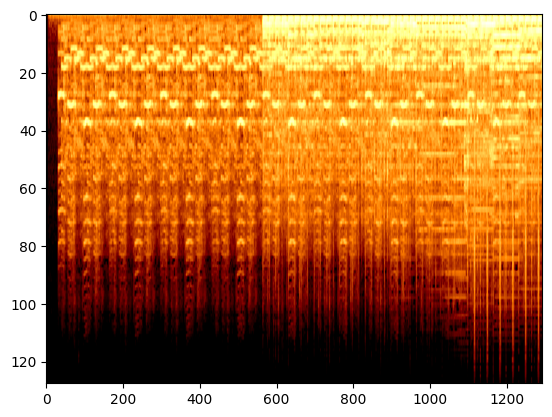

In [ ]:
plt.imshow(np.load('/content/mel_array/mel_array_40_44/Intense_mel/-3AmnRPImfk.npy'),aspect='auto' , cmap="afmhot")